### US Baby Names Database
Author: Garret O'Connell
Kaggle URL: https://www.kaggle.com/kaggle/us-baby-names

### The Data Set
US Social Security applications are a great way to track trends in how babies born in the US are named. Data.gov released two datasets: one at the national level and another at the state level fr the last 100 years. Note that only names with at least 5 babies born in the same year (/ state) are included in this dataset for privacy.


### Task 1.
Given a name, gender and year: The likelihood of that name being born in a specific state.

#### Algorithm choice
* The chosen machine learning algorithm for this question was Random Forest, an learning classifier that is accurate in many contexts.
* Random Forest is suitable for multi-class responses (e.g. which state a baby is born in), is resistant to overfitting, and makes few assumptions about the data.
* Random Forest requires little parameter tuning and are easily applied to a variety of data types.

#### Data cleaning and model fitting
* I used 5 fold cross-validation to assess model accuracy.
* The data set set was very large and this slowed model fitting. To reduce the data for quickly building a "prototype" model (to apply to full data later), I sampled 20 years of data which were spaced evenly apart in time, and then further reduced data by randomly sampling 5% of these data.
* Inspecting the data I observed the majority of observations (~95%) were accounted for by 5% of the levels in the name variable (see below figure for distribution of names). 

#### Inputs required
* You can enter your own test case to see in which state the model predicts a given name/gender/year is most likely to be born. The predict state and probabilities are outputed at the end of the notebook.

#### Results
* The Random Forests classified with 11% accuracy (base rate: ~2%).

### Task 2.

Given the state, name and year: The probability of that name being male or female.

#### Algorithm choice:
* The chosen machine learning algorithm for this question was K Nearest Neighbour (KNN).
* KNN is a non-parametric model that makes no assumption about the data distribution. 
* KNN allowed me to model the relationship between geographically neighbouring states. 
* KNN can also take multi-level features (unlike logistic regression) which was useful as encoding the numerous name levels as binary dummy variables could lead to memory errors.

#### Data cleaning and model fitting
* I chose a train-test data split of 4-1 to reduce overfitting.

* I removed older data keeping last 20 years to minimize to a dataset for building prototype model that was faster to fit.

* To reduce the high cardinality of the name variable I removed rarer names that were not in the top 10% of frequency. This retained the majority of the data (~95%) while removing 90% of the levels in the name variable.

* A new feature of Rank (rank of names by frequency per sate) was estimated to model the popularity of that name-gender combination in a given state.

* I entered longitudinal and latitudinal coordinates of the city capitals of each state to model geographical relationship between states.

* Examining the accuracies of various values for the k parameter (number of nearest neighbours), I chose a k of 20 which appeared to be where the drop in accuracy began to level off (see plot below).

#### Inputs required
* You can enter your own test case to see in which state the model predicts a given name/gender/year is most likely to be born. The predict state and probabilities are outputed at the end of the notebook.

#### Results
* The KNN classified with an accuracy of 88% (base rate = 50%). 

In [1]:
from collections import OrderedDict

# enter attributes for test case to submit to model
test_case = OrderedDict([('Name', "Taylor"), ('Year', 2011), ('Gender', "M")])

In [2]:
import os
import pandas as pd
import numpy as np

path = os.getcwd()
data_dir = os.path.join(os.path.sep.join(path.split(os.path.sep)[:-1]),'data')
df = pd.read_csv(os.path.join(data_dir,'StateNames.csv'), index_col = False) 

In [3]:
# remove ID as there is nothing to learn from this feature (it would just add some noise)
df = df.drop(['Id'], axis=1)

### Question 1.

In [4]:
# sample data evenly spaced across time to minimize to a smaller dataset for building model prototype
year_ratio = 20
year_ratio = (df["Year"].max()-df["Year"].min())/year_ratio
year_incl = np.arange(df["Year"].min(), df["Year"].max(), year_ratio)
year_incl = list(map(int, year_incl))
df = df[df['Year'].isin(year_incl)]

In [5]:
# record labels for decode after classification
cat_columns = ["Name","Gender","State"]
label_list = []
for column in cat_columns:
    df[column] = df[column].astype('category')
    label_list.append(dict( enumerate(df[column].cat.categories) ))
    df[column] = df[column].astype("category").cat.codes

In [6]:
# examine distribution of names
df_unique = df.groupby([ "Name", "Gender"], as_index=False).sum()
df_unique = df_unique.sort_values(by=['Count'],ascending=[False]).reset_index()

#### Data visualization

The majority of cases (~95%) were accounted for by 5% of the names which suggests the name variable was sparsely populated and training the model on only common names would improve processing efficiency (by reducing the cardinality of the names feature) without negatively affecting accuracy.

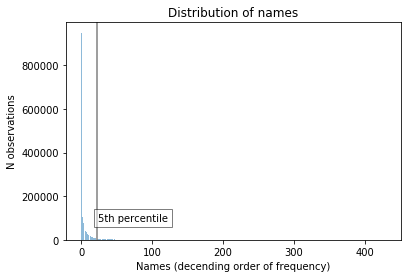

In [7]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# y axis ticks
y_pos = np.arange(len(df_unique.iloc[::50]))

# plot
plt.bar(y_pos, df_unique['Count'].iloc[::50], align='center', alpha=0.5)
plt.xlabel('Names (decending order of frequency)')
plt.ylabel('N observations')
plt.title('Distribution of names')
plt.axvline((len(df_unique.loc[0:len(df_unique)*.05])/50), color="gray")
plt.text(23, 100000, "5th percentile", va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5))
plt.show()

In [8]:
# expand count data as observation rows 
df = df.reindex(df.index.repeat(df.Count))

In [9]:
# randomly sample to reduce data
sample_ratio = .1
df = df.sample(frac=sample_ratio)

In [10]:
# separate predictors and target label data
df = df.set_index(df["Name"])
del df.index.name
df_predictor = df.drop(['Count','State'], axis = 1)
df_label = df['State']

In [11]:
from sklearn.preprocessing import MinMaxScaler

int_columns = ['Year']

# min/max scaling of integer features
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
df[int_columns] = scaler.fit_transform(df[int_columns])
#df[int_columns] = scaler.inverse_transform(df[int_columns])

In [12]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_predictor, df_label, random_state=0,train_size=0.2)

/Users/goconnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
# submit test case by recoding using same labelling as training data
name_code = [k for k, v in label_list[0].items() if v == test_case["Name"]]
gender_code = [k for k, v in label_list[1].items() if v == test_case["Gender"]]

# fill in estimated feature data for test case
X_case = pd.DataFrame([(name_code[0],min(year_incl, key=lambda x:abs(x-test_case["Year"])),gender_code[0])],columns=list(test_case.keys()))

In [14]:
# random forest model fitting

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf_rf = RF(n_jobs=1, random_state=0)
clf_rf.fit(X_train, y_train)
scores_rf = cross_val_score(clf_rf, X_train, y_train, cv=5)

#### Random Forest model fit results

The accuracy of the model on test data.

In [15]:
# assess accuracy
y_predict_rf = clf_rf.predict(X_test)
score_rf = accuracy_score(y_test, y_predict_rf)
print('Accuracy: ',score_rf)

Accuracy:  0.110760584415


#### Random Forest test case classification

The probability of the given name/gender/year case being born in a specific state.

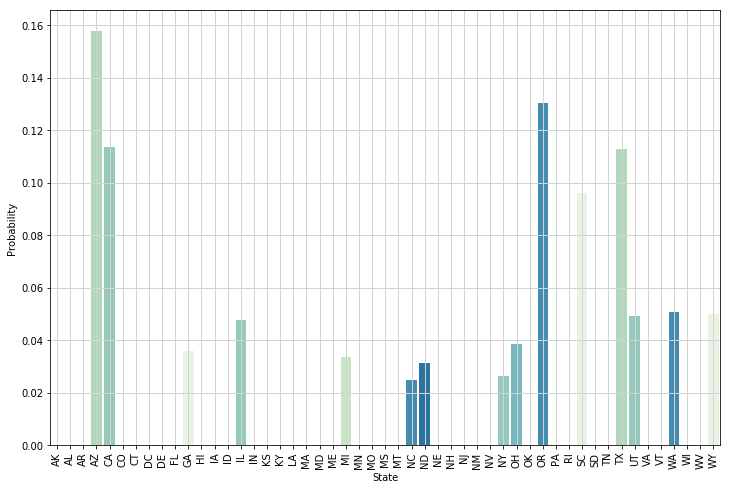

In [16]:
# distribution of probabilities (likelihood) across states

import seaborn as sns

# predict probabilities of test case gender
X_case_prob_rf = clf_rf.predict_proba(X_case)
prob_dist_rf = pd.DataFrame(columns=['State','Probability'])
prob_dist_rf["State"]=label_list[2].values()
prob_dist_rf["Probability"]=X_case_prob_rf[0]
              
# plot
plt.figure(figsize=(12,8))
ax = sns.barplot(x="State", y="Probability", data=prob_dist_rf, palette=sns.color_palette("GnBu", 10))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

#### Random Forest test case predicted label

The predicted state label of the given name/gender/year case.

In [17]:
# predict case label
label_rf = clf_rf.predict(X_case)
print('Predicted label: ',label_list[2][label_rf[0]])

Predicted label:  AZ


### Question 2.

In [18]:
from collections import OrderedDict

# enter attributes for test case to submit to model
test_case = OrderedDict([('Name', "Taylor"), ('Year', 2011), ('State', "FL")])

In [19]:
# reload data
df = pd.read_csv(os.path.join(data_dir,'StateNames.csv'), index_col = False) 

# remove ID as there is nothing to learn from this feature (it would just add some noise)
df = df.drop(['Id'], axis=1)

# sample data evenly spaced across time to minimize to a smaller dataset for building model prototype
year_ratio = 20
year_ratio = (df["Year"].max()-df["Year"].min())/year_ratio
year_incl = np.arange(df["Year"].min(), df["Year"].max(), year_ratio)
year_incl = list(map(int, year_incl))
df = df[df['Year'].isin(year_incl)]

# create new features 
df['Rank'] = df.groupby(['Year','State'])['Count'].rank(ascending=False)

In [20]:
# get latitude and longitude coordinates
regions = pd.read_csv(os.path.join(data_dir,'region_census.csv')) 
statenames = df['State'].map(regions.set_index('State Code')['State'])
capitals = pd.read_csv(os.path.join(data_dir,'state_capitals.csv')) 
df['Latitude'] = statenames.map(capitals.set_index('name')['latitude'])
df['Longtitude'] = statenames.map(capitals.set_index('name')['longitude'])

In [21]:
# record labels for decode after classification
cat_columns = ["Name","Gender","State"]
label_list = []
for column in cat_columns:
    df[column] = df[column].astype('category')
    label_list.append(dict( enumerate(df[column].cat.categories) ))
    df[column] = df[column].astype('category').cat.codes

In [22]:
# expand count data as observation rows 
df = df.reindex(df.index.repeat(df.Count))

In [24]:
# submit test case by recoding using same labelling as training data
name_code = [k for k, v in label_list[0].items() if v == test_case["Name"]]
state_code = [k for k, v in label_list[2].items() if v == test_case["State"]]

# fill in estimated feature data for test case
X_case = pd.DataFrame([(name_code[0],min(year_incl, key=lambda x:abs(x-test_case["Year"])),state_code[0])],columns=list(test_case.keys()))

# find corresponding cases to fill in estimated features
rank_test_case = df["Rank"].loc[(df["Name"] == name_code) & (df["Year"] == X_case["Year"].loc[0]) & (df["State"] == state_code)]
latitude_test_case = df["Latitude"].loc[(df["Name"] == name_code) & (df["Year"] == X_case["Year"].loc[0]) & (df["State"] == state_code)]
longtitude_test_case = df["Longtitude"].loc[(df["Name"] == name_code) & (df["Year"] == X_case["Year"].loc[0]) & (df["State"] == state_code)]

# fill data into case df
X_case["Rank"] = rank_test_case.iloc[0]
X_case["Latitude"] = latitude_test_case.iloc[0]
X_case["Longtitude"] = longtitude_test_case.iloc[0]

In [25]:
# randomly sample to reduce data
sample_ratio = .01
df = df.sample(frac=sample_ratio)

In [26]:
# separate predictors and target label data
df = df.set_index(df["Name"])
del df.index.name
df_predictor = df.drop(['Count','Gender'], axis = 1)
df_label = df['Gender']

In [27]:
from sklearn.preprocessing import MinMaxScaler

int_columns = ['Year','Latitude','Longtitude']

# min/max scaling of integer features
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
df[int_columns] = scaler.fit_transform(df[int_columns])
#df[int_columns] = scaler.inverse_transform(df[int_columns])

In [28]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_predictor, df_label, random_state=0,test_size=0.2)

#### K parameter selection

A range of values of K were fit and the value of 20 was chosen based on the below visualization indicating a levelling off of error rate increases.

In [29]:
# convert to correct data types
cat_columns = ['Name','State']
int_columns = ['Year','Rank','Latitude','Longtitude']
for column in cat_columns: X_train[column] = X_train[column].astype('category')
for column in cat_columns: X_test[column] = X_test[column].astype('category')
for column in int_columns: X_train[column] = X_train[column].astype('int')
for column in int_columns: X_test[column] = X_test[column].astype('int')

/Users/goconnell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/goconnell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/goconnell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [30]:
# determine optimal k using elbow method
 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
error_rate = []
K = [50,100,300,500]
for k in K:
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train,y_train)
    scores = cross_val_score(clf_knn, X_train, y_train, cv=5)
    error_rate.append(scores.mean())

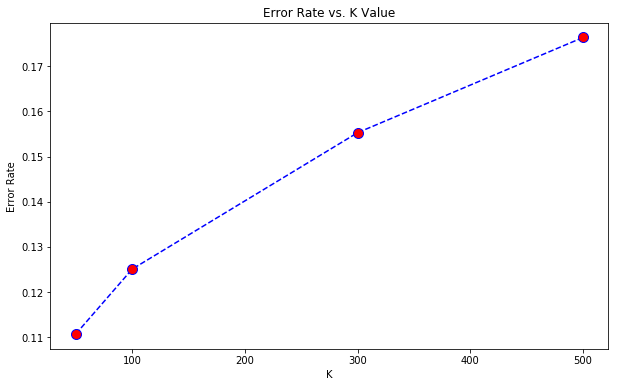

In [31]:
%matplotlib inline  

import matplotlib.pyplot as plt

# x axis ticks
K = [50,100,300,500]
# plot the elbow
plt.figure(figsize=(10,6))
plt.plot(K,(1-np.array(error_rate)),color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

#### KNN model fit results

The accuracy of the model on test data.

In [32]:
# assess accuracy
from sklearn.metrics import accuracy_score

clf_knn = KNeighborsClassifier(n_neighbors=100)
clf_knn.fit(X_train,y_train)
y_predict_knn = clf_knn.predict(X_test)
score_knn = accuracy_score(y_test, y_predict_knn)
print('Accuracy: ',score_knn)

Accuracy:  0.881215543902


#### KNN test case label probabilities

The probability of the given name/state/year case being a specific gender.

  Gender  Probability
0      F         0.66
1      M         0.34


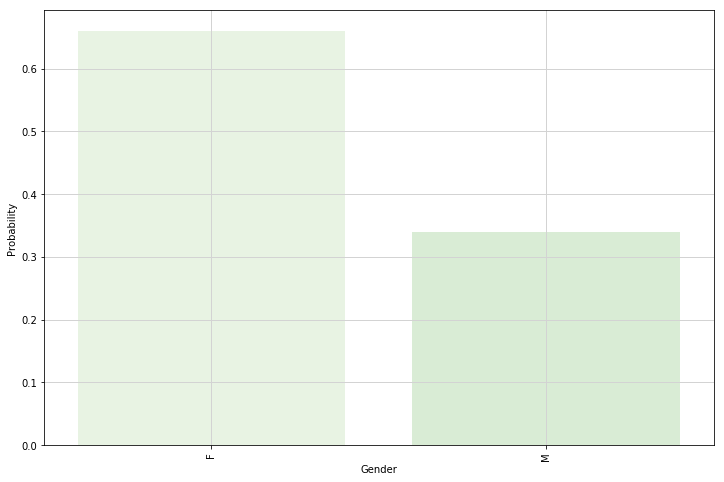

In [33]:
import seaborn as sns

# predict probabilities of test case gender
X_case_prob_knn = clf_knn.predict_proba(X_case)

# predict probabilities of test case gender
X_case_prob_knn = clf_knn.predict_proba(X_case)
prob_dist_knn = pd.DataFrame(columns=['Gender','Probability'])
prob_dist_knn["Gender"]=label_list[1].values()
prob_dist_knn["Probability"]=X_case_prob_knn[0]
print(prob_dist_knn)

# plot
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Gender", y="Probability", data=prob_dist_knn, palette=sns.color_palette("GnBu", 10))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

#### KNN test case predicted label

The predicted gender label of the given name/state/year case.

In [34]:
# predict case label
label_knn = clf_knn.predict(X_case)

# map predicted factor level to original label
print('Predicted label: ',label_list[1][label_knn[0]])

Predicted label:  F
